In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import glob
import plotly.io as pio
import itertools
from scipy.interpolate import interp1d

os.chdir('/Users/mmckay/phd_projects/analysis_routine/code/photometry_fns')
from isochrone_preprocessing_fns import *
from photmetry_catalog_preprocessing_fn import *
from plotting_fns import *
from tqdm import tqdm


# Directories
# /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phast_rgb_catalog.csv
WORK_DIR = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/'
CMB_TABLE_DIR = '/Users/mmckay/phd_projects/analysis_routine/DATA/CMD3_7_outputs/4gyr_isochrone_outputs/'
# RGB_ISO_DIR = ''
FIGURE_DIR = '/Users/mmckay/phd_projects/analysis_routine/FIGURES'

In [4]:
def series_to_array(df):
    # Convert the object to numpy array before indexing
    f475w_f814w_ecorr = np.array(df["f475w-f814w_ecorr"])
    f814w_vega_ecorr = np.array(df["f814w_vega_ecorr"])
    z_col_arr = np.array(df['interpolated_MH'])
    ra = np.array(df["ra"])
    dec = np.array(df["dec"])

    # Sort dataframe by Mini
    

    return f475w_f814w_ecorr, f814w_vega_ecorr, z_col_arr, ra, dec

def plot_catalog_CMD_and_Model_iso(catalog_df, rgb_selection_df, save_file):
    fig, axs = plt.subplots(1, 2, figsize=(25, 8), sharey=True, sharex=True)

    f475w_f814w_ecorr, f814w_vega_ecorr, z_col_arr, ra, dec = series_to_array(catalog_df)
    sns.kdeplot(
        x=f475w_f814w_ecorr,
        y=f814w_vega_ecorr,
        zorder=0,
        n_levels=10,
        thresh=0.01,
        fill=True,
        cbar=False,
        color="black",
        ax=axs[0],
    )

    f475w_f814w_ecorr, f814w_vega_ecorr, z_col_arr, ra, dec = series_to_array(rgb_selection_df)
    sns.kdeplot(
        x=f475w_f814w_ecorr,
        y=f814w_vega_ecorr,
        zorder=0,
        n_levels=10,
        thresh=0.01,
        fill=True,
        cbar=False,
        color="black",
        ax=axs[1],
    )


    for i in [axs[0], axs[1]]:
        # Zini_list = [0.0599, 0.03, 0.0152, 0.0001]
        MH_list = [0.6, 0.0, -0.58, -1.89]
        colors = ['darkred', 'black', 'orange', 'blue']
        # for Zini, color in zip(Zini_list, itertools.cycle(colors)):
        for mh, color in zip(MH_list, itertools.cycle(colors)):
            # Zini =  0.0152 # Gregersen et al 2015
            # Plot CMD with isochrone
            print(mh)
            isochrone_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/RGB_isochrone_table.csv')
            # isochrone_df = isochrone_df[isochrone_df["Zini"] == Zini]
            isochrone_df = isochrone_df[isochrone_df["MH"].round(2) == mh]
            # print(isochrone_df.head())
            if not isochrone_df.empty:
                sns.lineplot(
                    x="F475W_appmag-F814W_appmag",
                    y="F814W_appmag",
                    data=isochrone_df,
                    ax=i,
                    zorder=1,
                    color=color,
                    # s=20,
                    # label=f"Zini={Zini}",
                    label=f"log(M/H)={mh}",
                    sort = True,
                    linewidth=7,
                    # marker=True
                )
            else:
                print("dataframe is empty")

        # Set outer boundary
        x = [1.5, 2.8, 4, 5, 6, 7]
        y = [23, 23, 21.75, 21.4, 21.25, 21.1]
        # Create an interpolation function
        interp_func = interp1d(x, y, bounds_error=False, fill_value="extrapolate")
        # Interpolate x and y values
        x_interp = np.linspace(min(x), max(x), 1000)
        y_interp = interp_func(x_interp)

        # Set inner boundary
        x1 = [1.5, 1.6, 1.8]
        y1 = [23, 21.7, 20.3]
        interp_func1 = interp1d(x1, y1, bounds_error=False, fill_value="extrapolate")
        x1_interp = np.linspace(min(x1), max(x1), 1000)
        y1_interp = interp_func1(x1_interp)

        x2 = [7, 6, 5, 4, 2.8, 1.8]
        y2 = [21.1, 20.7, 20.25, 20.15, 20.1, 20.3]
        interp_func2 = interp1d(x2, y2, bounds_error=False, fill_value="extrapolate")
        x2_interp = np.linspace(min(x2), max(x2), 1000)
        y2_interp = interp_func2(x2_interp)

        i.plot(x_interp, y_interp, color="black", linestyle="-", linewidth=1)
        i.plot(x1_interp, y1_interp, color="black", linestyle="-", linewidth=1)
        i.plot(x2_interp, y2_interp, color="black", linestyle="-", linewidth=1)
        
        i.set_xlabel(r"$F475W_{0}-F814W_{0}$", fontsize=35)
        i.set_ylabel(r"$F814W_{0}$", fontsize=35)
        i.tick_params(axis='x', labelsize=25)
        i.tick_params(axis='y', labelsize=25)


    # axs[0].set_xlabel("F475W-F814W")
    # axs[0].set_ylabel("F814W")
    axs[0].set_title(f"Complete Catalog: Color-Magnitude Diagram N={len(f475w_f814w_ecorr)}", fontsize=25)
    axs[1].set_title(f"RGB Selection: Color-Magnitude Diagram N={len(f475w_f814w_ecorr)}", fontsize=25)
    axs[0].legend(fontsize=20)
    axs[1].legend(fontsize=20)
    axs[1].invert_yaxis()

    plt.tight_layout()
    plt.savefig(FIGURE_DIR+'/'+save_file, dpi=300, bbox_inches="tight")
    plt.show()

### Process the 

In [10]:


all_isochrone_df = read_sort_isochrone_table(filename=CMB_TABLE_DIR+'output901257569509.dat', 
                                            output_dir=WORK_DIR)

all_isochrone_df = read_sort_isochrone_table(filename=CMB_TABLE_DIR+'output458449038052.dat',
                                            output_dir=WORK_DIR )

rgb_isochrone_df = isochrone_rgb_selection(isochrone_dirpath=WORK_DIR,
                                            output_dir=WORK_DIR)

In [2]:
# all_isochrone_df = read_sort_isochrone_table(filename=CMB_TABLE_DIR+'output901257569509.dat', 
#                                             output_dir=WORK_DIR)

Processing file: 99218line [01:19, 1241.75line/s]


Merged Dataframe Complete


In [3]:
# all_isochrone_df = read_sort_isochrone_table(filename=CMB_TABLE_DIR+'output458449038052.dat',
#                                             output_dir=WORK_DIR )

Processing file: 103488line [01:26, 1198.72line/s]


Merged Dataframe Complete


In [11]:
# rgb_isochrone_df = isochrone_rgb_selection(isochrone_dirpath=WORK_DIR,
#                                             output_dir=WORK_DIR)

In [7]:
# Making interactive plots with plotly

import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import pandas as pd


df1 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/RGB_Zini_0.0001.csv')
df2 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/RGB_Zini_0.03.csv')
df3 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/RGB_Zini_0.0599.csv')


# Create a subplot with 1 row and 2 columns
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=("RGB_Zini_0.0001", "RGB_Zini_0.03", "RGB_Zini_0.0599",))

# Add scatter plot for df1
fig.add_trace(go.Scatter(x=df1['F475W_appmag-F814W_appmag'], y=df1['F814W_appmag'], mode='markers', name='df1', 
                        #  marker=dict(color=df1['Mini'], 
                        #              colorscale='magma_r', 
                                    #  colorbar=dict(title='Mini', orientation='h', len=0.45, xanchor="right", yanchor="middle", titleside="top", x=0.4, y=1.1))
                         ), 
                                    row=1, col=1)

# Add scatter plot for df2
fig.add_trace(go.Scatter(x=df2['F475W_appmag-F814W_appmag'], y=df2['F814W_appmag'], mode='markers', name='df2', 
                        #  marker=dict(color=df2['Mini'], 
                        #              colorscale='magma_r', 
                                    #  colorbar=dict(title='Mini', orientation='h', len=0.45, xanchor="left", yanchor="middle", titleside="top", x=0.6, y=1.1)
                         ), 
                                     row=1, col=2)

fig.add_trace(go.Scatter(x=df3['F475W_appmag-F814W_appmag'], y=df3['F814W_appmag'], mode='markers', name='df3', 
                        #  marker=dict(color=df3['Mini'], 
                        #              colorscale='magma_r', 
                                    #  colorbar=dict(title='Mini', orientation='h', len=0.45, xanchor="left", yanchor="middle", titleside="top", x=0.6, y=1.1))
                         ), 
                                     row=1, col=3)

# Update layout
fig.update_layout(height=700, width=1000, title_text="Subplots", title='Isochrone CMDs')

# Inverse y-axes
fig.update_yaxes(autorange="reversed")

# Show the plot
fig.show()

In [6]:
# Making interactive plots with plotly

import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import pandas as pd


df1 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB_AGB/RGB_AGB_Zini_0.0001.csv')
df2 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB_AGB/RGB_AGB_Zini_0.03.csv')
df3 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB_AGB/RGB_AGB_Zini_0.0599.csv')


# Create a subplot with 1 row and 2 columns
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=("RGB_AGB_Zini_0.0001", "RGB_AGB_Zini_0.03", "RGB_AGB_Zini_0.0599",))

# Add scatter plot for df1
fig.add_trace(go.Scatter(x=df1['F475W_appmag-F814W_appmag'], y=df1['F814W_appmag'], mode='markers', name='df1', 
                        #  marker=dict(color=df1['Mini'], 
                        #              colorscale='magma_r', 
                                    #  colorbar=dict(title='Mini', orientation='h', len=0.45, xanchor="right", yanchor="middle", titleside="top", x=0.4, y=1.1))
                         ), 
                                    row=1, col=1)

# Add scatter plot for df2
fig.add_trace(go.Scatter(x=df2['F475W_appmag-F814W_appmag'], y=df2['F814W_appmag'], mode='markers', name='df2', 
                        #  marker=dict(color=df2['Mini'], 
                        #              colorscale='magma_r', 
                                    #  colorbar=dict(title='Mini', orientation='h', len=0.45, xanchor="left", yanchor="middle", titleside="top", x=0.6, y=1.1)
                         ), 
                                     row=1, col=2)

fig.add_trace(go.Scatter(x=df3['F475W_appmag-F814W_appmag'], y=df3['F814W_appmag'], mode='markers', name='df3', 
                        #  marker=dict(color=df3['Mini'], 
                        #              colorscale='magma_r', 
                                    #  colorbar=dict(title='Mini', orientation='h', len=0.45, xanchor="left", yanchor="middle", titleside="top", x=0.6, y=1.1))
                         ), 
                                     row=1, col=3)

# Update layout
fig.update_layout(height=700, width=1000, title_text="Subplots", title='Isochrone CMDs')

# Inverse y-axes
fig.update_yaxes(autorange="reversed")

# Show the plot
fig.show()

## Plot the figure isochrones over the current CMD


In [15]:
interpolated_phast_rgb_agb_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB_AGB/interpolated_phast_rgb_agb_selection.csv')
interpolated_phast_rgb_agb_df = interpolated_phast_rgb_agb_df.sample(n=10000)
interpolated_phast_rgb_agb_df = interpolated_phast_rgb_agb_df.sort_values(by='interpolated_Mini', ascending=False)


phast_g15_rgb_cut_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB_AGB/phast_rgb_selection.csv')
phast_g15_rgb_cut_df = phast_g15_rgb_cut_df.sample(n=10000)





In [48]:
interpolated_phast_rgb_agb_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'ra', 'dec', 'f475w_vega', 'f475w_snr',
       'f475w_crowd', 'f475w_sharp', 'f475w_flag', 'f814w_vega', 'f814w_snr',
       'f814w_crowd', 'f814w_sharp', 'f814w_flag', 'f275w_vega', 'f275w_snr',
       'f275w_crowd', 'f275w_sharp', 'f275w_flag', 'f814w_vega_ecorr',
       'f475w_vega_ecorr', 'f475w-f814w_ecorr', 'interpolated_MH',
       'interpolated_Mini', 'interpolated_int_IMF', 'interpolated_Mass',
       'interpolated_logL', 'interpolated_logTe', 'interpolated_logg'],
      dtype='object')

In [59]:
# def series_to_array(df):
#     # Convert the object to numpy array before indexing
#     f475w_f814w_ecorr = np.array(df["f475w-f814w_ecorr"])
#     f814w_vega_ecorr = np.array(df["f814w_vega_ecorr"])
#     z_col_arr = np.array(df[z_col])
#     ra = np.array(df["ra"])
#     dec = np.array(df["dec"])

#     # Sort dataframe by Mini
    

#     return f475w_f814w_ecorr, f814w_vega_ecorr, z_col_arr, ra, dec


In [43]:
isochrone_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/RGB_isochrone_table.csv')
isochrone_df = isochrone_df[isochrone_df["MH"] == 3.78640e-01]
isochrone_df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Zini,MH,logAge,Mini,int_IMF,...,F475Wmag,F555Wmag,F606Wmag,F625Wmag,F775Wmag,F814Wmag,F475W_appmag,F814W_appmag,F475Wmag-F814Wmag,F475W_appmag-F814W_appmag
28,115,115,115,115,115,0.0327,0.37864,9.60206,1.418642,2.531738,...,0.876,0.124,-0.365,-0.678,-1.423,-1.535,25.326,22.915,2.411,2.411
29,116,116,116,116,116,0.0327,0.37864,9.60206,1.418794,2.531752,...,0.823,0.065,-0.431,-0.746,-1.513,-1.629,25.273,22.821,2.452,2.452
30,117,117,117,117,117,0.0327,0.37864,9.60206,1.418937,2.531765,...,0.776,0.016,-0.487,-0.804,-1.603,-1.722,25.226,22.728,2.498,2.498
31,118,118,118,118,118,0.0327,0.37864,9.60206,1.419063,2.531777,...,0.737,-0.026,-0.536,-0.854,-1.686,-1.810,25.187,22.640,2.547,2.547
32,119,119,119,119,119,0.0327,0.37864,9.60206,1.419181,2.531788,...,0.699,-0.066,-0.584,-0.903,-1.769,-1.897,25.149,22.553,2.596,2.596


0.6
0.0
-0.58
-1.89
0.6
0.0
-0.58
-1.89


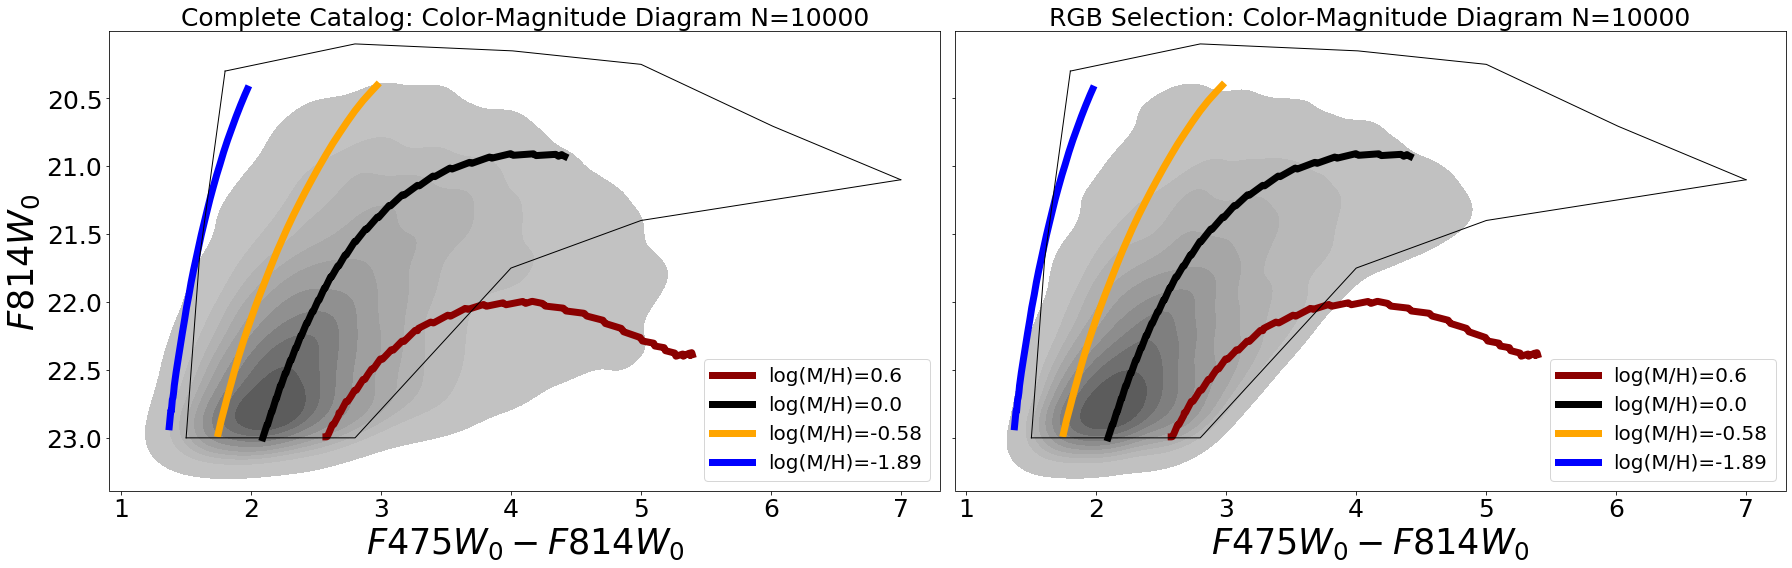

In [5]:
# z_col = 'interpolated_MH'
# Create a figure and subplots
# /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phast_rgb_catalog.csv
interpolated_phast_rgb_agb_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phast_rgb_catalog.csv')
# interpolated_phast_rgb_agb_df = pd.read_csv(f'{WORK_DIR}/RGB/interpolated_phast_g15_rgb_catalog.csv')
interpolated_phast_rgb_agb_df = interpolated_phast_rgb_agb_df.sample(n=10000)
interpolated_phast_rgb_agb_df = interpolated_phast_rgb_agb_df.sort_values(by='interpolated_Mini', ascending=False)
phast_g15_rgb_cut_df = pd.read_csv(WORK_DIR+'RGB/interpolated_phast_g15_rgb_selection.csv')
phast_g15_rgb_cut_df = phast_g15_rgb_cut_df.sample(n=10000)

plot_catalog_CMD_and_Model_iso(catalog_df=interpolated_phast_rgb_agb_df, rgb_selection_df=phast_g15_rgb_cut_df, save_file='phast_cmd_and_isochrones.jpeg')

0.6
0.0
-0.58
-2.19
0.6
0.0
-0.58
-2.19


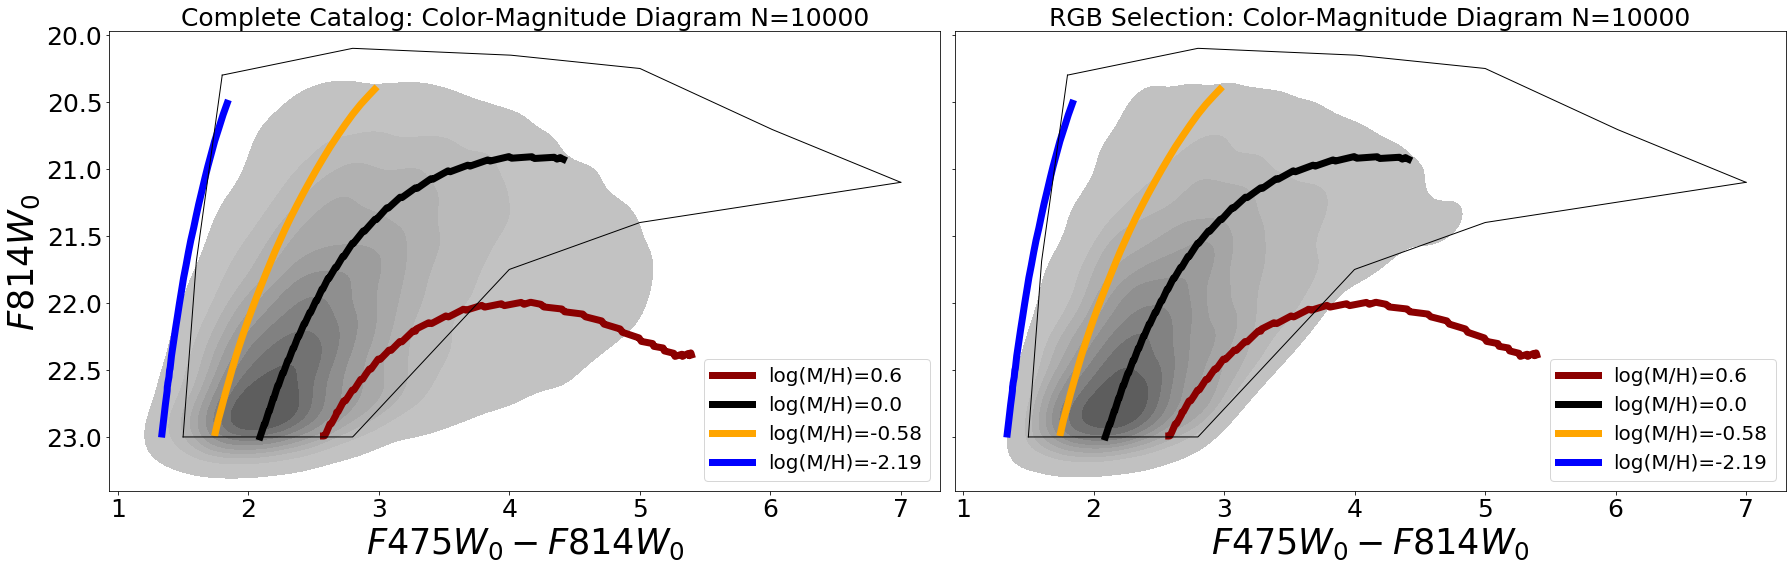

In [51]:
# z_col = 'interpolated_MH'
# Create a figure and subplots
# /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phat_rgb_catalog.csv
interpolated_phat_rgb_agb_df = pd.read_csv(WORK_DIR+'/RGB/interpolated_phat_rgb_catalog.csv')
interpolated_phat_rgb_agb_df = interpolated_phat_rgb_agb_df.sample(n=10000)
interpolated_phat_rgb_agb_df = interpolated_phat_rgb_agb_df.sort_values(by='interpolated_Mini', ascending=False)

# '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phast_g15_rgb_selection.csv'
phat_g15_rgb_cut_df = pd.read_csv(WORK_DIR+'RGB/interpolated_phat_g15_rgb_selection.csv')
phat_g15_rgb_cut_df = phat_g15_rgb_cut_df.sample(n=10000)

plot_catalog_CMD_and_Model_iso(catalog_df=interpolated_phat_rgb_agb_df, rgb_selection_df=phat_g15_rgb_cut_df, save_file='phat_cmd_and_isochrones.jpeg')

In [ ]:
# z_col = 'interpolated_MH'
# Create a figure and subplots

interpolated_phast_rgb_agb_df = pd.read_csv(WORK_DIR+'/RGB_AGB/interpolated_phast_rgb_agb_selection.csv')
interpolated_phast_rgb_agb_df = interpolated_phast_rgb_agb_df.sample(n=10000)
interpolated_phast_rgb_agb_df = interpolated_phast_rgb_agb_df.sort_values(by='interpolated_Mini', ascending=False)

phast_g15_rgb_cut_df = pd.read_csv(WORK_DIR+'/RGB_AGB/phast_rgb_selection.csv')
phast_g15_rgb_cut_df = phast_g15_rgb_cut_df.sample(n=10000)

plot_catalog_CMD_and_Model_iso(catalog_df=interpolated_phast_rgb_agb_df, rgb_selection_df=phast_g15_rgb_cut_df, save_file='phast_cmd_and_isochrones.jpeg')

In [66]:
# Zini_list = [0.0152, 0.0599, 0.03, 0.0001]
# colors = ['red', 'blue', 'green', 'orange']
# # isochrone_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB_AGB/RGB_AGB_isochrone_table.csv')
# fig, axs = plt.subplots(1,1,figsize=(10, 10))
# for Zini, color in zip(Zini_list, itertools.cycle(colors)):
#     # Zini =  0.0152 # Gregersen et al 2015
#     # Plot CMD with isochrone
#     print(Zini)
#     isochrone_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB_AGB/RGB_AGB_isochrone_table.csv')
#     isochrone_df = isochrone_df[isochrone_df["Zini"] == Zini]
#     # print(isochrone_df.head())
#     sns.lineplot(
#         x="F475W_appmag-F814W_appmag",
#         y="F814W_appmag",
#         data=isochrone_df,
#         ax=axs,
#         zorder=0,
#         color=color,
#         # s=20,
#         label=f"Zini={Zini}",
#     )

# axs.invert_yaxis()  # Assuming you want to invert the y-axis for astronomical plots
# axs.legend()
# plt.show()

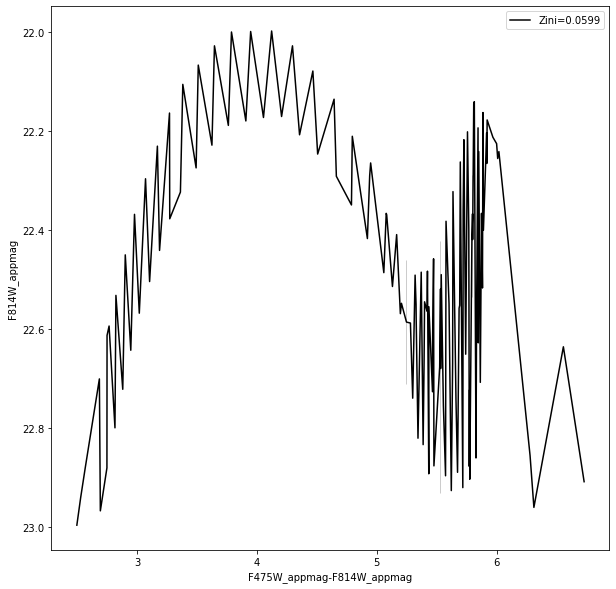

In [26]:
Zini =  0.0599 # Gregersen et al 2015
isochrone_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB_AGB/RGB_AGB_isochrone_table.csv')
# Plot CMD with isochrone
isochrone_df = isochrone_df[isochrone_df["Zini"] == Zini]
fig, axs = plt.subplots(figsize=(10, 10))
sns.lineplot(
    x="F475W_appmag-F814W_appmag",
    y="F814W_appmag",
    data=isochrone_df,
    ax=axs,
    zorder=0,
    color="black",
    # s=20,
    label=f"Zini={Zini}",
)

axs.invert_yaxis()  # Assuming you want to invert the y-axis for astronomical plots
axs.legend()
plt.show()
# sns.scatterplot(x=f475w_f814w_ecorr, y=f814w_vega_ecorr, hue=z_col_arr, ax=axs[1], zorder=0, size=1, palette='magma')

# Preprocessing phast photometry catalog


In [ ]:
phast_fits_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/phast_f475W_f814W_table.csv'
output_file = '/Users/mmckay/phd_projects/analysis_routine/DATA/test_modules/reduced_phast_catalog.csv'
phast_df = make_optical_photmetry_table(photometry_fits_filepath=phast_fits_filepath, output_filepath=output_file)

# Testing plot function

In [ ]:
m31_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_m31_MH_catalog.csv')
m31_df.columns

In [ ]:
import os
os.chdir('/Users/mmckay/phd_projects/analysis_routine/code/photometry_fns')
from isochrone_preprocessing_fns import *
from photmetry_catalog_preprocessing_fn import *
from plotting_fns import *
# csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_m31_MH_catalog.csv'
csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_phat_rgb_agb_dataset.csv'

f814w_col = 'f814w_vega_ecorr'
f475w_f814_col = 'f475w-f814w_ecorr'
z_col = 'interpolated_MH'
savefile_path = '/Users/mmckay/phd_projects/analysis_routine/DATA/test_modules/rgb_slection.csv'
savefig_filepath = '/Users/mmckay/phd_projects/analysis_routine/FIGURES/cmd_plot.jpeg'

plot_CMD(csv_filepath, f814w_col, f475w_f814_col, z_col, savefile=True, apply_phat_rgb_MH_selection=True, save_rgb_selection=True, save_filepath=savefile_path, savefig_filepath=savefig_filepath)

In [ ]:
csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/reduced_phat_catalog.csv'
f814w_col = 'f814w_vega_ecorr'
f475w_f814_col = 'f475w-f814w_ecorr'
z_col = 'f814w_snr'
savefile_path = '/Users/mmckay/phd_projects/analysis_routine/DATA/phat_rgb_selection.csv'
savefig_filepath = '/Users/mmckay/phd_projects/analysis_routine/FIGURES/phat_rgb_selection.jpeg'

plot_CMD(csv_filepath, f814w_col, f475w_f814_col, z_col, savefile=True, apply_phat_rgb_MH_selection=True, save_rgb_selection=True, save_filepath=savefile_path, savefig_filepath=savefig_filepath)

In [ ]:
csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/reduced_phast_catalog.csv'
f814w_col = 'f814w_vega_ecorr'
f475w_f814_col = 'f475w-f814w_ecorr'
z_col = 'f814w_snr'
savefile_path = '/Users/mmckay/phd_projects/analysis_routine/DATA/phast_rgb_selection.csv'
savefig_filepath = '/Users/mmckay/phd_projects/analysis_routine/FIGURES/phast_rgb_selection.jpeg'

plot_CMD(csv_filepath, f814w_col, f475w_f814_col, z_col, savefile=True, apply_phat_rgb_MH_selection=True, save_rgb_selection=True, save_filepath=savefile_path, savefig_filepath=savefig_filepath)

# Interpolateion

In [ ]:
import os
os.chdir('/Users/mmckay/phd_projects/analysis_routine/code/photometry_fns')
from isochrone_preprocessing_fns import *
from photmetry_catalog_preprocessing_fn import *
from plotting_fns import *

# RGB
catalog_linear_interpolation(catalog_csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/phast_rgb_selection.csv', 
                             isochrone_csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/test_modules/RGB_isochrone_tables/RGB_isochrone_table.csv', 
                             output_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phast_rgb_selection.csv', 
                             savefile=True)

plot_CMD(csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_phast_rgb_selection.csv', f814w_col='f814w_vega_ecorr', f475w_f814_col='f475w-f814w_ecorr', z_col='interpolated_MH', savefile=True, apply_phat_rgb_MH_selection=False, save_rgb_selection=False, save_filepath='', savefig_filepath='/Users/mmckay/phd_projects/analysis_routine/FIGURES/cmd_phast_rgb_selection.jpeg')

# RGB and AGB stars
catalog_linear_interpolation(catalog_csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/phast_rgb_selection.csv', 
                             isochrone_csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/RGB_isochrone_tables/RGB_AGB_isochrone_table.csv', 
                             output_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phast_rgb_agb_selection.csv', 
                             savefile=True)

plot_CMD(csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_phast_rgb_agb_selection.csv', f814w_col='f814w_vega_ecorr', f475w_f814_col='f475w-f814w_ecorr', z_col='interpolated_MH', savefile=True, apply_phat_rgb_MH_selection=False, save_rgb_selection=False, save_filepath='', savefig_filepath='/Users/mmckay/phd_projects/analysis_routine/FIGURES/cmd_phast_rgb_agb_selection.jpeg')


In [ ]:
# PHAT
# RGB
catalog_linear_interpolation(catalog_csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/phat_rgb_selection.csv', 
                             isochrone_csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/test_modules/RGB_isochrone_tables/RGB_isochrone_table.csv', 
                             output_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phat_rgb_selection.csv', 
                             savefile=True)

plot_CMD(csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_phat_rgb_selection.csv', f814w_col='f814w_vega_ecorr', f475w_f814_col='f475w-f814w_ecorr', z_col='interpolated_MH', savefile=True, apply_phat_rgb_MH_selection=False, save_rgb_selection=False, save_filepath='', savefig_filepath='/Users/mmckay/phd_projects/analysis_routine/FIGURES/cmd_phat_rgb_selection.jpeg')

# RGB and AGB stars
catalog_linear_interpolation(catalog_csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/phat_rgb_selection.csv', 
                             isochrone_csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/RGB_isochrone_tables/RGB_AGB_isochrone_table.csv', 
                             output_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phat_rgb_agb_selection.csv', 
                             savefile=True)

plot_CMD(csv_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_phat_rgb_agb_selection.csv', f814w_col='f814w_vega_ecorr', f475w_f814_col='f475w-f814w_ecorr', z_col='interpolated_MH', savefile=True, apply_phat_rgb_MH_selection=False, save_rgb_selection=False, save_filepath='', savefig_filepath='/Users/mmckay/phd_projects/analysis_routine/FIGURES/cmd_phat_rgb_agb_selection.jpeg')

# Compare interpolated and reduced datasets

In [ ]:
interpolated_phast_rgb_agb_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_phast_rgb_agb_selection.csv')
interpolated_phast_rgb_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_phast_rgb_selection.csv')
phast_rgb_selection_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_rgb_selection.csv')



In [ ]:
phast_rgb_selection_df[['f814w_vega_ecorr', 'f475w-f814w_ecorr']].describe()

In [ ]:
interpolated_phast_rgb_df[['f814w_vega_ecorr', 'f475w-f814w_ecorr']].describe()

In [ ]:
interpolated_phast_rgb_agb_df[['f814w_vega_ecorr', 'f475w-f814w_ecorr']].describe()

# Plot interpolated datasets


In [ ]:
import os
os.chdir('/Users/mmckay/phd_projects/analysis_routine/code/photometry_fns')
from isochrone_preprocessing_fns import *
from photmetry_catalog_preprocessing_fn import *
from plotting_fns import *

# PHAST
photometry_binned_spatial_map(catalog_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phast_rgb_selection.csv', z_col='interpolated_MH', output_dir='/Users/mmckay/phd_projects/analysis_routine/FIGURES', catalog_name='phast_rgb')
photometry_binned_spatial_map(catalog_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phast_rgb_agb_selection.csv', z_col='interpolated_MH', output_dir='/Users/mmckay/phd_projects/analysis_routine/FIGURES', catalog_name='phast_rgb+agb')

# PHAT
photometry_binned_spatial_map(catalog_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phat_rgb_selection.csv', z_col='interpolated_MH', output_dir='/Users/mmckay/phd_projects/analysis_routine/FIGURES', catalog_name='phat_rgb')
photometry_binned_spatial_map(catalog_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phat_rgb_agb_selection.csv', z_col='interpolated_MH', output_dir='/Users/mmckay/phd_projects/analysis_routine/FIGURES', catalog_name='phat_rgb_agb')


In [ ]:
# Kde contour plots for phat and phast
csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phat_rgb_selection.csv'
df = pd.read_csv(csv_filepath)
# df = df.replace([np.inf, -np.inf], np.nan)


In [ ]:
df.columns

In [ ]:
csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phat_rgb_selection.csv'
df = pd.read_csv(csv_filepath)
df = df[df['interpolated_MH'] <= 0.5]


# Create a density contour plot using Plotly Express
fig = px.density_contour(df, x='f475w-f814w_ecorr', y='f814w_vega_ecorr')

# Add labels and title
fig.update_layout(xaxis_title='F475W-F814W', yaxis_title='F814W', title=f'{csv_filepath.split("/")[-1:]}: N={len(df)}')

# Reverse the y-axis
fig.update_layout(yaxis=dict(autorange="reversed"))

# Save the plot as a JPEG file
pio.write_image(fig, '/Users/mmckay/phd_projects/analysis_routine/FIGURES/CMD_contour_plot.jpeg')

# Show the plot
# fig.show()

In [ ]:
csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/Interpolated_phat_rgb_selection.csv'
df = pd.read_csv(csv_filepath)
df = df[df['interpolated_MH'] <= 0.5]


# Create a density contour plot using Plotly Express
fig = px.density_contour(df, x='ra', y='dec')

# Add labels and title
fig.update_layout(xaxis_title='RA', yaxis_title='DEC', title=f'{csv_filepath.split("/")[-1:]}: N={len(df)}')

# Reverse the y-axis
# fig.update_layout(yaxis=dict(autorange="reversed"))

# Save the plot as a JPEG file
pio.write_image(fig, '/Users/mmckay/phd_projects/analysis_routine/FIGURES/spatial_map_contour_plot.jpeg')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram2dContour(
        x = df['ra'],
        y = df['dec'],
        colorscale = 'Blues',
        reversescale = True,
        xaxis = 'x',
        yaxis = 'y'
    ))
fig.add_trace(go.Scatter(
        x = df['ra'],
        y = df['dec'],
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'rgba(0,0,0,0.3)',
            size = 3
        )
    ))
pio.write_image(fig, '/Users/mmckay/phd_projects/analysis_routine/FIGURES/spatial_map_contour_plot.jpeg')
# fig.show()

In [ ]:
plt.hist(df['interpolated_MH'].to_numpy(), bins=30)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Create the contour plot
plt.contour(X, Y, Z)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour Plot')

# Show the plot
plt.show()


In [ ]:
phatter_isochrone_csv = cmd_isochrone_processing(isochrone_csv='/Users/mmckay/phd_projects/analysis_routine/DATA/phatter_RGB_isochrone_tables/RGB_AGB_isochrone_table.csv', distance_modules=24.67, save_tables=True)